In [2]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from imblearn.over_sampling import SMOTE       #over sampling of minority class in imbalanced data
from imblearn.combine import SMOTEENN          #over sampling of minority class in imbalanced data
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,average_precision_score,precision_recall_curve,precision_score


import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_columns', 100)

In [3]:
# read the input files and look at the top few lines #
data_path = "/Users/venkatasravankanukolanu/Documents/Data Files/credit_fraud/"
data_df= pd.read_csv(data_path+"creditcard.csv")
data_df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [4]:
data_df['std_amount'] = StandardScaler().fit_transform(data_df['Amount'].reshape(-1, 1))
data_df= data_df.drop(['Time','Amount'],axis=1)
data_df.head(2)

/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475


Since V1 through V28 are principal compotents from PCA on the actual data, V1 through V28 are independent. This eliminates the problem of multicolinearity in the data. 

Since the data set meets the assumptions of Binary Logistic Regression Model i.e.

1. The dependent variable is binary.
2. The factor level 1 of the dependent variable represents the desired outcome i.e. fraud.
3. The independent variables are independent of each other since they are principal components.

In [5]:
response='Class'
predictors=data_df.columns[data_df.columns != 'Class']

#### Split the data as test and train

In [6]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(data_df[predictors], data_df[response], test_size=0.1, random_state=2,stratify=data_df[response])

### Variable Importance

#### Recursive Feature Elimination through Cross-Validation

In [7]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
def rfe_cv(x_train_data,y_train_data):
    rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='average_precision')
    rfecv.fit(x_train_data, y_train_data)
    
    selected_features=list(x_train_data.columns[rfecv.support_])
    
    print("Optimal number of features: %d" % rfecv.n_features_)
    print('Selected features: %s' % selected_features)

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=(10,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (Average Precision)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    return(selected_features)

Optimal number of features: 24
Selected features: ['V1', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V13', 'V14', 'V15', 'V16', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'std_amount']


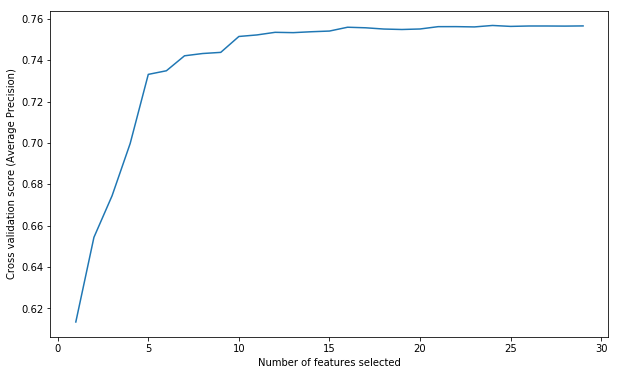

In [8]:
preds=rfe_cv(df_train_x, df_train_y)

### Baseline: Logistic Regression with Validation Set Approach

Training a logistic regression and testing it on a validation set.

In [9]:
# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
def logit(x,y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2,stratify=y)

    # check classification scores of logistic regression
    logreg = LogisticRegression(penalty = 'l2', C =0.1, class_weight ='balanced',random_state = 2)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_pred_proba = logreg.predict_proba(X_test)[:, 1]
    area_prc = average_precision_score(y_test, y_pred_proba)
    print('Logit Model Results:')
    print(logreg.__class__.__name__+" Area under PR-Curve is %2.3f" % area_prc)

    precision, recall, thr = precision_recall_curve(y_test, y_pred_proba)
    
    idx = np.min(np.where(precision > 0.3)) # index of the first threshold for which the precision is 0.3
    
    
    plt.figure(figsize=(10,6))
    plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,recall[idx]], [precision[idx],precision[idx]], 'k--', color='blue')
    plt.plot([recall[idx],recall[idx]], [0,precision[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a precision of %.3f " % precision[idx] +  
          "and a recall of %.3f" % (recall[idx])+ 
      ", i.e. area under PR-Curve of %.2f%%." % ((precision[idx])*recall[idx]*100))

Logit Model Results:
LogisticRegression Area under PR-Curve is 0.530


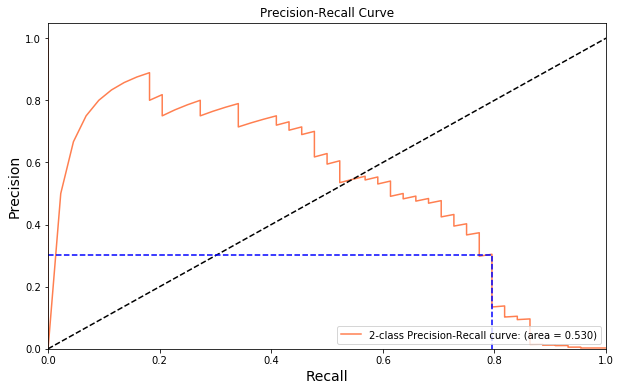

Using a threshold of 0.920 guarantees a precision of 0.302 and a recall of 0.795, i.e. area under PR-Curve of 24.00%.


In [10]:
logit(df_train_x[preds],df_train_y)

This is not the best method but it gives a recall of 79.5% i.e. it correctly predicts fradulent transactions 79.5% of the time but only 30.2% of those predict fraud transactions were really fradulent. The threshold was conservatively set at 0.92 to predict fraud correctly 79.5% of the time, at the cost of wrongly predicting a transaction as fraud 69.8% of the time.
Investigating non-fradulent transactions almost 70% of the time is a big waste of resources to the business so we need to improve the model by improving precision and also recall.

### Logistic Regression with 5-fold Cross Validation

In [45]:
from sklearn.model_selection import cross_validate

scoring = {'area under PRC': 'average_precision','precision': 'precision','recall': 'recall'}

modelCV = LogisticRegression(penalty = 'l2', C =0.1, class_weight ='balanced',random_state = 2)

results = cross_validate(modelCV,df_train_x[preds] , df_train_y, cv=5, scoring=list(scoring.values()), 
                         return_train_score=False)
print"Average Recall from 5-fold CV is %2.2f%%"% ((results['test_recall'].mean())*100)
print"Average Precision from 5-fold CV is %2.2f%%"% ((results['test_precision'].mean())*100)

Average Recall from 5-fold CV is 90.30%
Average Precision from 5-fold CV is 5.54%


As we can clearly see that the 5-fold test average recall is 90.3% and precision is 5.5%, it means the model is predicting fraud transactions correctly 90.3% but only 5.5% of the predicted fraud transactions are actually fraud. This is resulting in a very conservative model. We will see if this can be improved by balancing the data set.

### Balanced Bagging with Logistic Regression

In this method, we will use random undersampling of the majority class and do bagging using logistic regression model. The undersampling would improve the imbalance of classes and bagging reduces the variance due to small sample size.

In [11]:
from imblearn.ensemble import BalancedBaggingClassifier 

In [44]:
def balanced_bagging_logit(x,y,num_est):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2,stratify=y)

    est= LogisticRegression(penalty = 'l2', C =0.1,class_weight ='balanced',random_state = 2)
    model = BalancedBaggingClassifier(base_estimator=est, n_estimators=num_est, ratio='majority',random_state=2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    area_prc = average_precision_score(y_test, y_pred_proba)
    print('Logit Model Results:')
    print(model.__class__.__name__+" Area under PR-Curve is %2.3f" % area_prc)

    precision, recall, thr = precision_recall_curve(y_test, y_pred_proba)

    idx = np.min(np.where(precision > 0.55)) # index of the first threshold for which recall is 0.8


    plt.figure(figsize=(10,6))
    plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,recall[idx]], [precision[idx],precision[idx]], 'k--', color='blue')
    plt.plot([recall[idx],recall[idx]], [0,precision[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a precision of %.3f " % precision[idx] +  
              "and a recall of %.3f" % (recall[idx])+ 
          ", i.e. area under PR-Curve of %.2f%%." % ((precision[idx])*recall[idx]*100))

Logit Model Results:
BalancedBaggingClassifier Area under PR-Curve is 0.684


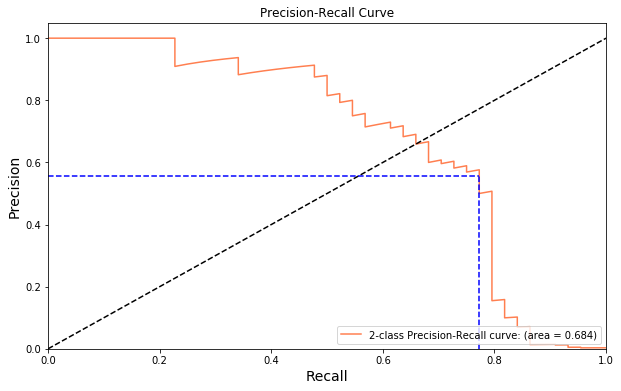

Using a threshold of 0.922 guarantees a precision of 0.557 and a recall of 0.773, i.e. area under PR-Curve of 43.07%.


In [45]:
balanced_bagging_logit(df_train_x[preds],df_train_y,100)

This approach definetly improved the model. We are correctly predicting fraud 77.3% of the time and 55.7% of the predicted fraudulent transactions are actually fraudulent.